In [1]:
import numpy as np
import pandas as pd
from keras.engine.topology import merge
from keras.layers import Dense, Dropout, Activation, LSTM, Conv1D, MaxPooling1D, Flatten, AtrousConvolution1D, Input
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


In [2]:
## Data preparation

In [3]:
data= pd.read_csv('/Users/arshiyaaggarwal/Desktop/Fms_Project/code/data/^DJI.csv')
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4271,2017-11-27,23552.859375,23638.919922,23545.019531,23580.779297,23580.779297,296320000
4272,2017-11-28,23625.189453,23849.609375,23617.109375,23836.710938,23836.710938,319240000
4273,2017-11-29,23883.259766,23959.759766,23872.589844,23940.679688,23940.679688,401410000
4274,2017-11-30,24013.800781,24327.820313,24013.800781,24272.349609,24272.349609,488200000
4275,2017-12-01,24305.400391,24322.060547,23921.900391,24231.589844,24231.589844,417910000


In [4]:
data= data.dropna(axis=0)
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4271,2017-11-27,23552.859375,23638.919922,23545.019531,23580.779297,23580.779297,296320000
4272,2017-11-28,23625.189453,23849.609375,23617.109375,23836.710938,23836.710938,319240000
4273,2017-11-29,23883.259766,23959.759766,23872.589844,23940.679688,23940.679688,401410000
4274,2017-11-30,24013.800781,24327.820313,24013.800781,24272.349609,24272.349609,488200000
4275,2017-12-01,24305.400391,24322.060547,23921.900391,24231.589844,24231.589844,417910000


In [5]:
data= data.values[:, 1:5]
print data.shape

(4276, 4)


In [6]:
print data[:6, :]

[[10377.330078 10604.459961 10319.30957 10560.950195]
 [10576.780273 10917.299805 10576.780273 10898.719727]
 [10896.139648 10896.139648 10620.860352 10664.379883]
 [10644.660156 10689.019531 10583.230469 10617.360352]
 [10632.139648 10803.540039 10631.860352 10712.910156]
 [10719.360352 10792.160156 10670.05957 10725.799805]]


In [7]:
y= data[1:, 3]
print y.shape
X= data[:4275,:]
print X.shape

(4275,)
(4275, 4)


In [8]:
y= (y- min(y))/(max(y)- min(y))
print y[4270:]
print y[:7]

[0.9609839991623761 0.9754227755909837 0.9812883322331646 1.0
 0.9977004752838762]
[0.2455061392540156 0.2322854972004963 0.2296328181756039
 0.2350234070545823 0.23575059639087165 0.23814659118191125
 0.23962306262608365]


In [9]:
X= (X- np.min(X,axis=0))/(np.max(X, axis=0)-np.min(X,axis=0))
print X.shape
print X[:3, :]

(4275, 4)
[[0.2192915864574453 0.22106956373653716 0.2194135977236257
  0.22645035256860355]
 [0.23071040945868904 0.23882618237200137 0.23408943537613414
  0.2455061392540156]
 [0.24899421297621796 0.2376251434208518 0.23660200117712055
  0.2322854972004963]]


In [10]:
## Input layer preparation

In [11]:
time_steps= 100
X_new= np.zeros((X.shape[0] - time_steps +1, 100, X.shape[1]))
y_new= np.zeros((y.shape[0] -time_steps +1,))
for ix in range(X_new.shape[0]):
    for jx in range(time_steps):
        X_new[ix, jx, :]= X[ix +jx, :]
    y_new[ix]= y[ix + time_steps -1]
print X_new.shape, y_new.shape

(4176, 100, 4) (4176,)


In [12]:
## split into train and test sets

In [13]:
split = int(0.8*data.shape[0])
X_train = X_new[:split]
X_test = X_new[split:]

y_train = y_new[:split]
y_test = y_new[split:]

print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(3420, 100, 4) (3420,)
(756, 100, 4) (756,)


In [14]:
## Model fitting

In [ ]:
## Model - 1 - main - with residual learning

In [15]:
x= Input(shape= (100, 4))
x_side= Conv1D(64, 1, border_mode='causal', activation='relu')(x)
pool= MaxPooling1D(pool_length=2)(x_side)
dil_conv1= AtrousConvolution1D(64, 3, atrous_rate=2, border_mode='causal', activation='relu')(x)
pool1= MaxPooling1D(pool_length=2)(dil_conv1)
out1= merge([pool, pool1], mode= 'sum', output_shape= (50,64))
lstm= LSTM(50, return_sequences= True)(out1)
dropout= Dropout(0.1)(lstm)
x_n= Conv1D(32, 1, border_mode='causal', activation='relu')(dropout)
pool_n= MaxPooling1D(pool_length=2)(x_n)
dil_conv2= AtrousConvolution1D(32, 3, atrous_rate=2, border_mode='causal', activation='relu')(dropout)
pool2= MaxPooling1D(pool_length=2)(dil_conv2)
out2= merge([pool_n, pool2], mode= 'sum', output_shape= (25,32))
conv1= Conv1D(16, 3, border_mode='causal')(out2)
flat= Flatten()(conv1)
dense= Dense(output_dim=1, activation='linear')(flat)

In [ ]:
model = Model(input=x, output=dense)
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=256, nb_epoch=5, validation_data = (X_test, y_test), verbose=2)

Train on 3420 samples, validate on 756 samples
Epoch 1/5
5s - loss: 0.0010 - acc: 2.9240e-04 - val_loss: 0.0017 - val_acc: 0.0013
Epoch 2/5
5s - loss: 3.0093e-04 - acc: 2.9240e-04 - val_loss: 5.6833e-04 - val_acc: 0.0013
Epoch 3/5
5s - loss: 3.5594e-04 - acc: 2.9240e-04 - val_loss: 4.6210e-04 - val_acc: 0.0013
Epoch 4/5


In [ ]:
## Model - 2 - simple - without residual learning

In [26]:
model = Sequential()
model.add(AtrousConvolution1D(64, 5, atrous_rate=2, border_mode='same', input_shape= (100,4)))
model.add(MaxPooling1D(pool_length=2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.1))
model.add(AtrousConvolution1D(32, 3, atrous_rate=2, border_mode='same'))
model.add(MaxPooling1D(pool_length=2))
model.add(Flatten())
model.add(Dense(output_dim=1))
model.add(Activation('linear'))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
atrousconvolution1d_9 (AtrousCon (None, 100, 64)       1344        atrousconvolution1d_input_2[0][0]
____________________________________________________________________________________________________
maxpooling1d_12 (MaxPooling1D)   (None, 50, 64)        0           atrousconvolution1d_9[0][0]      
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 50, 50)        23000       maxpooling1d_12[0][0]            
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 50, 50)        0           lstm_2[0][0]                     
___________________________________________________________________________________________

In [24]:
model.compile(loss='mse', optimizer='adagrad', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=256, nb_epoch=200, validation_data = (X_test, y_test), verbose=2)

Train on 3420 samples, validate on 756 samples
Epoch 1/200
5s - loss: 0.2340 - acc: 2.9240e-04 - val_loss: 0.0409 - val_acc: 0.0013
Epoch 2/200
6s - loss: 0.0047 - acc: 2.9240e-04 - val_loss: 0.0201 - val_acc: 0.0013
Epoch 3/200
5s - loss: 0.0031 - acc: 2.9240e-04 - val_loss: 0.0088 - val_acc: 0.0013
Epoch 4/200
5s - loss: 0.0021 - acc: 2.9240e-04 - val_loss: 0.0029 - val_acc: 0.0013
Epoch 5/200
5s - loss: 0.0018 - acc: 2.9240e-04 - val_loss: 0.0032 - val_acc: 0.0013
Epoch 6/200
5s - loss: 0.0016 - acc: 2.9240e-04 - val_loss: 0.0023 - val_acc: 0.0013
Epoch 7/200
5s - loss: 0.0016 - acc: 2.9240e-04 - val_loss: 0.0021 - val_acc: 0.0013
Epoch 8/200
5s - loss: 0.0015 - acc: 2.9240e-04 - val_loss: 0.0022 - val_acc: 0.0013
Epoch 9/200
5s - loss: 0.0016 - acc: 2.9240e-04 - val_loss: 0.0022 - val_acc: 0.0013
Epoch 10/200
5s - loss: 0.0015 - acc: 2.9240e-04 - val_loss: 0.0021 - val_acc: 0.0013
Epoch 11/200
5s - loss: 0.0015 - acc: 2.9240e-04 - val_loss: 0.0021 - val_acc: 0.0013
Epoch 12/200
5s 

In [ ]:
## Evaluation of the model and display of the results

In [24]:
score= model.evaluate(X_test, y_test, batch_size=256)

756/756 [==============================] - 0s     


In [25]:
print score

[0.00039541598707536066, 0.0013227512488368327]


In [26]:
y_pred= model.predict(X_test)

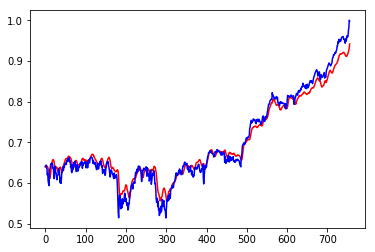

In [27]:
plt.plot(y_pred, 'r-')
plt.plot(y_test, 'b-')
plt.show()

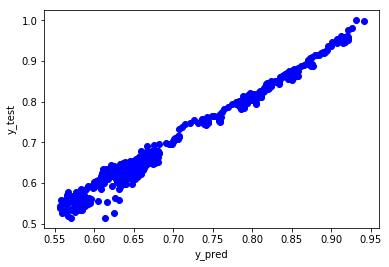

In [28]:
plt.plot (y_pred, y_test, 'bo')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()